<form action="index.ipynb">
    <input type="submit" value="Return to Index" style="background-color: green; color: white; width: 150px; height: 35px; float: right"/>
</form>

# Banana Example
Author(s): Paul Miles | Date Created: June 18, 2018

This technical example constructs a non-Gaussian target distribution by twisting two first dimensions of Gaussian
distribution. The Jacobian of the transformation is 1, so it is easy to calculate the right probability regions for the banana and study different adaptive methods.

The basics of the model are as follows.
$$B_f(x_i, a, b) = [ax_1, \frac{x_2}{a}-b(a^2x_1^2 + a^2), x_3, ..., x_{npar}]$$
$$B_f^{-1}(x_i, a, b) = [x_1 /a, ax_2 + ab(x_1^2 + a^2), x_3, ..., x_{npar}]$$

We can construct a sum-of-squares function
$$B_{sos}(x_i, a, b, \mu_i, \lambda) = B_f^{-1}(x_i-\mu_i, a, b) \cdot \lambda \cdot B_f^{-1}(x_i - \mu_i, a, b)$$
where $\mu_i$ are the centers for our target distributions, $\lambda$ is the target precision, and the banana parameters are $a$ and $b$.  For this particular example we consider the problem where we have 2 unknown parameters with center $\mu_i = 0$, and we have a target correlation of $\rho = 0.9$ for the first two dimensions.  We subsequently define the target precision matrix $\lambda$
\begin{equation}
    \lambda = \sigma^{-1} = \begin{bmatrix}
    1 & \rho & 0 & \\
    \rho & 1 & \\
    0 & & 1 \\
    & & & \ddots \\
    & & & & 1
  \end{bmatrix}^{-1}
\end{equation}

Note, for a comparison between using MCMC algorithms in Matlab, Python, and R, see [here](https://github.com/prmiles/mcmc_banana_examples/blob/master/mcmc_banana_examples.pdf).

In [1]:
# import required packages
import numpy as np
from pymcmcstat.MCMC import MCMC
from pymcmcstat.plotting.utilities import generate_ellipse
import matplotlib.pyplot as plt
import pymcmcstat
print(pymcmcstat.__version__)

1.9.0


We create a class to initialize model parameters

In [2]:
class Banana_Parameters:

    def __init__(self, rho=0.9, npar=12, a=1, b=1, mu=None):
        self.rho = rho
        self.a = a
        self.b = b
        self.sig = np.eye(npar)
        self.sig[0,1] = rho
        self.sig[1,0] = rho
        self.lam = np.linalg.inv(self.sig)
        self.npar = npar
        if mu is None:
            self.mu = np.zeros([npar, 1])
            
npar = 6 # number of model parameters
udobj = Banana_Parameters(npar=npar) # user defined object

# Initialize MCMC object
- initialize data structure
- assign model parameters
- define simulation options

In [3]:
# Initialize MCMC object
mcstat = MCMC()
mcstat.data.add_data_set(np.zeros(1), np.zeros(1),
                         user_defined_object=udobj)
# Add model parameters
for ii in range(npar):
    mcstat.parameters.add_model_parameter(
        name=str('$x_{}$'.format(ii + 1)),
        theta0=0.0)
# Define options
mcstat.simulation_options.define_simulation_options(
    nsimu=4.0e3,
    qcov=np.eye(npar)*5,
    method='dram')

We define a series of functions to evaluation the sum-of-squares error

In [4]:
# Define model object
def bananafunction(x, a, b):
    response = x
    response[:, 0] = a*x[:, 0]
    response[:, 1] = x[:, 1]*a**(-1) - b*((a*x[:, 0])**(2) + a**2)
    return response

def bananainverse(x, a, b):
    response = x
    response[0] = x[0]*a**(-1)
    response[1] = x[1]*a + a*b*(x[0]**2 + a**2)
    return response

def bananass(theta, data):
    udobj = data.user_defined_object[0]
    lam = udobj.lam
    mu = udobj.mu
    a = udobj.a
    b = udobj.b
    npar = udobj.npar
    x = np.array([theta])
    x = x.reshape(npar, 1)
    baninv = bananainverse(x - mu, a, b)
    stage1 = np.matmul(baninv.transpose(),lam)
    stage2 = np.matmul(stage1, baninv)
    
    return stage2
    
mcstat.model_settings.define_model_settings(sos_function=bananass)

# Run Simulation

In [5]:
mcstat.run_simulation()


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
     $x_1$:  0.00e+00 [     -inf,       inf] N( 0.00e+00,      inf)
     $x_2$:  0.00e+00 [     -inf,       inf] N( 0.00e+00,      inf)
     $x_3$:  0.00e+00 [     -inf,       inf] N( 0.00e+00,      inf)
     $x_4$:  0.00e+00 [     -inf,       inf] N( 0.00e+00,      inf)
     $x_5$:  0.00e+00 [     -inf,       inf] N( 0.00e+00,      inf)
     $x_6$:  0.00e+00 [     -inf,       inf] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 4000 of 4000 complete in 0.9 sec

Extract results and plot chain panel

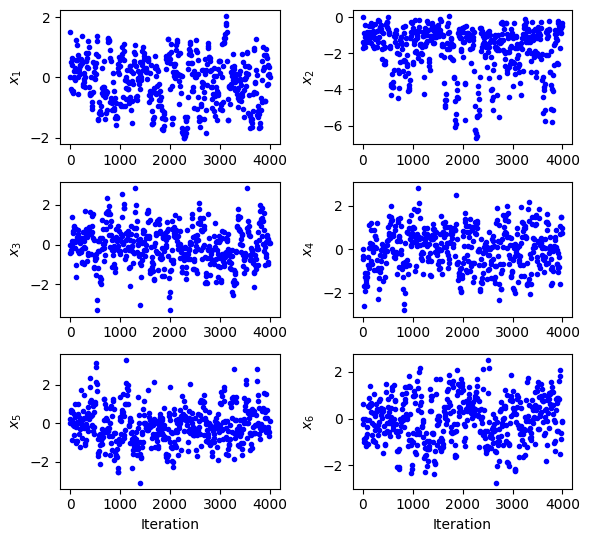

In [7]:
from pymcmcstat import mcmcplot as mcp
# Extract results
results = mcstat.simulation_results.results
chain = results['chain']
s2chain = results['s2chain']
names = results['names'] # parameter names
# plot chain panel
settings = dict(fig=dict(figsize=(6, 6)))
f = mcp.plot_chain_panel(chain, names, settings=settings)

# Pairwise Correlation
Here we plot the pairwise correlation as well as 50% and 95% critical regions.  These critical regions have a shape resembling a banana, hence the name of the example.

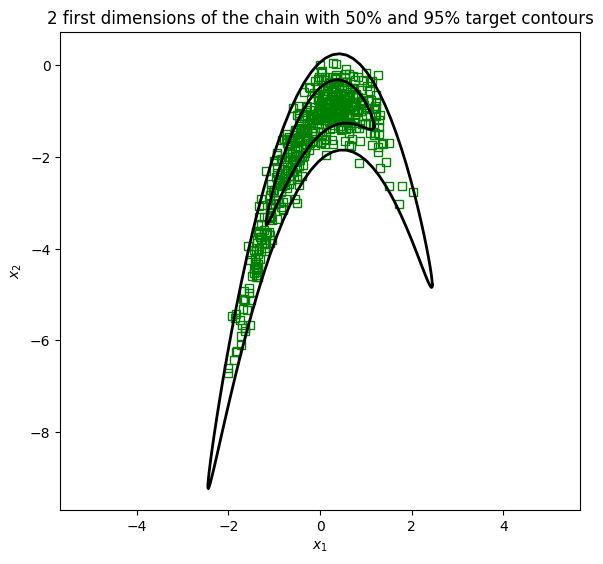

In [8]:
# plot pairwise correlation
settings = dict(
    fig=dict(figsize=(6, 6)),
    plot=dict(
        color='g',
        marker='s',
        mfc='none'))
mcp.plot_pairwise_correlation_panel(
    chain[:, 0:2], names[0:2], settings=settings)
# calculate contours for 50% and 95% critical regions
c50 = 1.3863 # critical values from chisq(2) distribution
c95 = 5.9915
xe50, ye50 = generate_ellipse(udobj.mu, c50*udobj.sig[0:2, 0:2])
xe95, ye95 = generate_ellipse(udobj.mu, c95*udobj.sig[0:2, 0:2])
bxy50 = bananafunction(np.array([xe50, ye50]).T, udobj.a, udobj.b)
bxy95 = bananafunction(np.array([xe95, ye95]).T, udobj.a, udobj.b)
# add countours to pairwise plot
plt.plot(bxy50[:,0], bxy50[:,1], 'k-', LineWidth=2)
plt.plot(bxy95[:,0], bxy95[:,1], 'k-', LineWidth=2)
plt.axis('equal')
tmp = plt.title('2 first dimensions of the chain with 50% and 95% target contours')